In [120]:
import sys
from pathlib import Path

import numpy as np
from astropy import table
import random
from scipy import interpolate, optimize, signal
import betterplotlib as bpl

bpl.set_style()

# Get all the final postprocessed output catalogs

In [10]:
data_dir = Path("../data/").resolve()

In [17]:
catalogs = []
for galaxy in data_dir.iterdir():
    for item in (data_dir / galaxy / "size").iterdir():
        if item.name.startswith("final_catalog_final_30"):
            this_cat = table.Table.read(item, format="ascii.ecsv")
            this_cat["galaxy"] = galaxy.name
            if "profile_diff_max" in this_cat.colnames:
                catalogs.append(this_cat)

In [18]:
big_catalog = table.vstack(catalogs, join_type="inner")

# Then make cumulative histograms of some of the fit quality metrics

In [19]:
def make_cumulative_histogram(values):
    """
    Create the line to be plotted for a cumulative histogram
    
    Throws out nans

    :param values: data
    :return: List of xs and ys to be plotted for the cumulative histogram
    """
    sorted_values = np.sort(values)
    # throw out nans
    sorted_values = sorted_values[~np.isnan(sorted_values)]
    ys = np.arange(1, 1 + len(sorted_values), 1)
    assert len(ys) == len(sorted_values)
    return sorted_values, ys / max(ys)

In [124]:
quality_colnames = ["profile_diff_mad", "profile_diff_max", "profile_diff_last"]

In [126]:
boundaries = dict()
for col in quality_colnames:
    if "rms" in col:
        continue
    xs, ys = make_cumulative_histogram(big_catalog[col])
    # find the first x at which y goes above 0.9
    idx = np.argmin(np.abs(ys - 0.9))
    boundaries[col] = xs[idx]

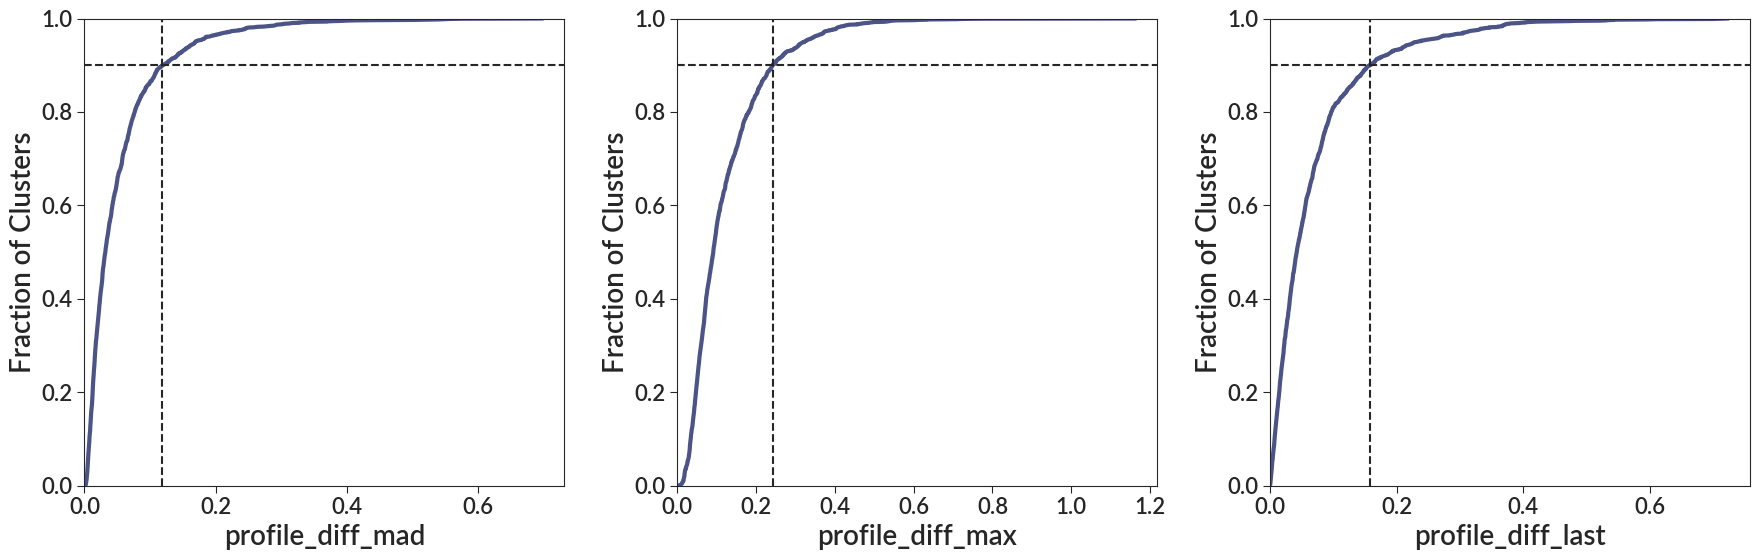

In [129]:
fig, axs = bpl.subplots(ncols=len(quality_colnames), figsize=[6*len(quality_colnames), 6])
axs = axs.flatten()

for ax, col in zip(axs, quality_colnames):
    ax.plot(*make_cumulative_histogram(big_catalog[col]))
    ax.add_labels(col, "Fraction of Clusters")
    ax.set_limits(0, y_min=0, y_max=1)
    ax.axhline(0.9, ls="--")
    ax.axvline(boundaries[col], ls="--")
fig.savefig("quality_cuts.png")

For a final version, using the second derivative would probably be a more quantitiative version of doing this, but for now we'll just throw out the last 10%.

In [118]:
boundaries

{'profile_diff_mad': 0.11860371059644502,
 'profile_diff_max': 0.2422950857276166,
 'profile_diff_last': 0.15756898102675565}

In [112]:
good_colnames = []
for col in boundaries:
    big_catalog[col + "_good"] = big_catalog[col] < boundaries[col]
    
    good_colnames.append(col + "_good")

Then print out how many met each criteria, and how those intersected.

In [113]:
big_catalog["num_failed"] = -99
for row in big_catalog:
    row["num_failed"] = 3 - np.sum([row[col] for col in good_colnames])

In [128]:
def print_row(row):
    output = "\t\t"
    output += f"{row['galaxy']:9} {row['ID']:5}, "
    output += f"R_eff {row['r_eff_pixels_rmax_15pix_best']:5.2f} pix, "
    output += f"max {row['profile_diff_max']:4.2f}, "
    output += f"MAD {row['profile_diff_mad']:4.2f}, "
    output += f"last {row['profile_diff_last']:4.2f}, "
    output += f"RMS {row['fit_rms']:6.2f}, "
    print(output)

print(len(big_catalog), "total clusters")

for n_fail in range(4):
    mask = big_catalog["num_failed"] == n_fail
    subset = big_catalog[mask]
    
    print(f"\n\n{100 * len(subset) / len(big_catalog):.2f}% of clusters failed {n_fail} criteria")
    
    if n_fail == 0:
        for row in subset[:30]:
            print_row(row)
    
    if n_fail == 1:
        for col in good_colnames:
            failure_mask = subset[col] == False
            n_failure = np.sum(failure_mask)
            print(f"\t{n_failure} of these solely failed {col}")
            for row in subset[failure_mask][:10]:
                print_row(row)
            
    if n_fail == 2:
        for col in good_colnames:
            success_mask = subset[col] == True
            n_success = np.sum(success_mask)
            print(f"\t{n_success} of these solely passed {col}")
            for row in subset[success_mask][:10]:
                print_row(row)
    if n_fail == 3:
        for row in subset[:30]:
            print_row(row)

1965 total clusters


83.77% of clusters failed 0 criteria
		ngc6503      27, R_eff  3.35 pix, max 0.05, MAD 0.01, last 0.01, RMS   0.54, 
		ngc6503      40, R_eff  1.17 pix, max 0.06, MAD 0.03, last 0.03, RMS   1.69, 
		ngc6503      59, R_eff  2.82 pix, max 0.06, MAD 0.01, last 0.02, RMS   0.51, 
		ngc6503     131, R_eff  0.67 pix, max 0.05, MAD 0.01, last 0.01, RMS   1.73, 
		ngc6503     146, R_eff  1.55 pix, max 0.06, MAD 0.01, last 0.02, RMS   2.03, 
		ngc6503     148, R_eff  1.02 pix, max 0.05, MAD 0.03, last 0.04, RMS   5.44, 
		ngc6503     197, R_eff  2.60 pix, max 0.05, MAD 0.00, last 0.01, RMS   0.46, 
		ngc6503     226, R_eff  1.08 pix, max 0.10, MAD 0.06, last 0.06, RMS   6.11, 
		ngc6503     277, R_eff  2.05 pix, max 0.05, MAD 0.00, last 0.01, RMS   0.49, 
		ngc6503     322, R_eff  0.98 pix, max 0.02, MAD 0.01, last 0.00, RMS   6.28, 
		ngc6503     363, R_eff  2.31 pix, max 0.05, MAD 0.02, last 0.04, RMS   0.39, 
		ngc6503     507, R_eff  2.29 pix, max 0.03, MAD 0.01, last 

In [131]:
np.logical_and([0, 1, 1], [1, 1, 1])

array([False,  True,  True])

# Calculate second derivates to have a quantitative estimate of where to cut

I tried a spline, but that didn't really work. Let's try a functional form, particularly the CDF of the exponential

In [23]:
def exponential_cdf(x, l):
    return 1 - np.exp(-l * x)

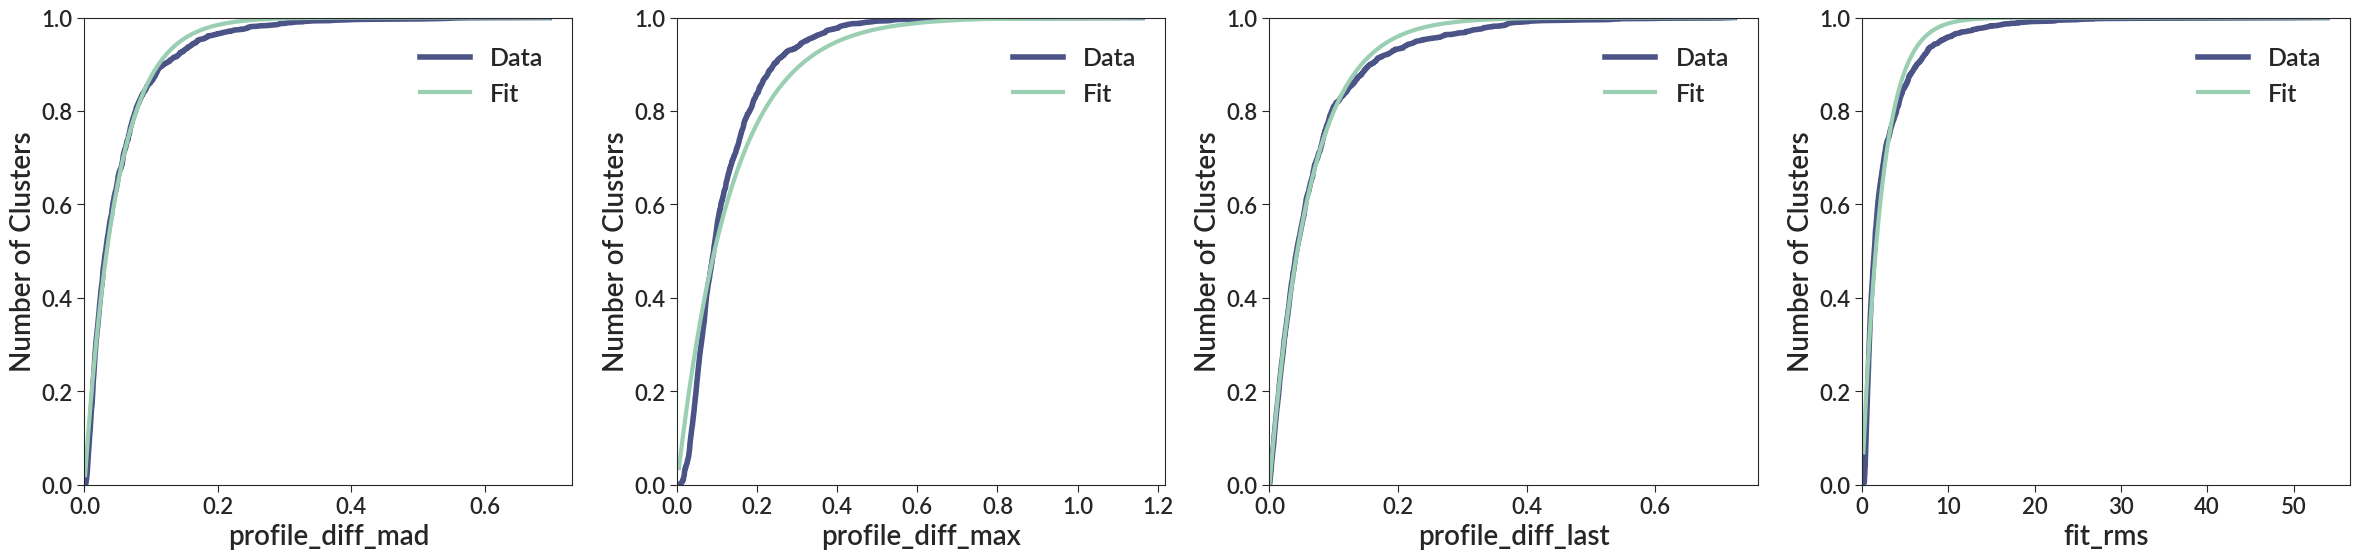

In [29]:
fig, axs = bpl.subplots(ncols=len(quality_colnames), figsize=[6*len(quality_colnames), 6])
axs = axs.flatten()

for ax, col in zip(axs, quality_colnames):
    xs, ys = make_cumulative_histogram(big_catalog[col])
    
    ax.plot(xs, ys, lw=4, label="Data")
    ax.add_labels(col, "Number of Clusters")
    ax.set_limits(0, y_min=0, y_max=1)
    
    l = optimize.curve_fit(f=exponential_cdf, xdata=xs, ydata=ys)[0]
    
    fit_ys = exponential_cdf(xs, l)
    
    ax.plot(xs, fit_ys, lw=3, label="Fit")
    
    ax.legend()

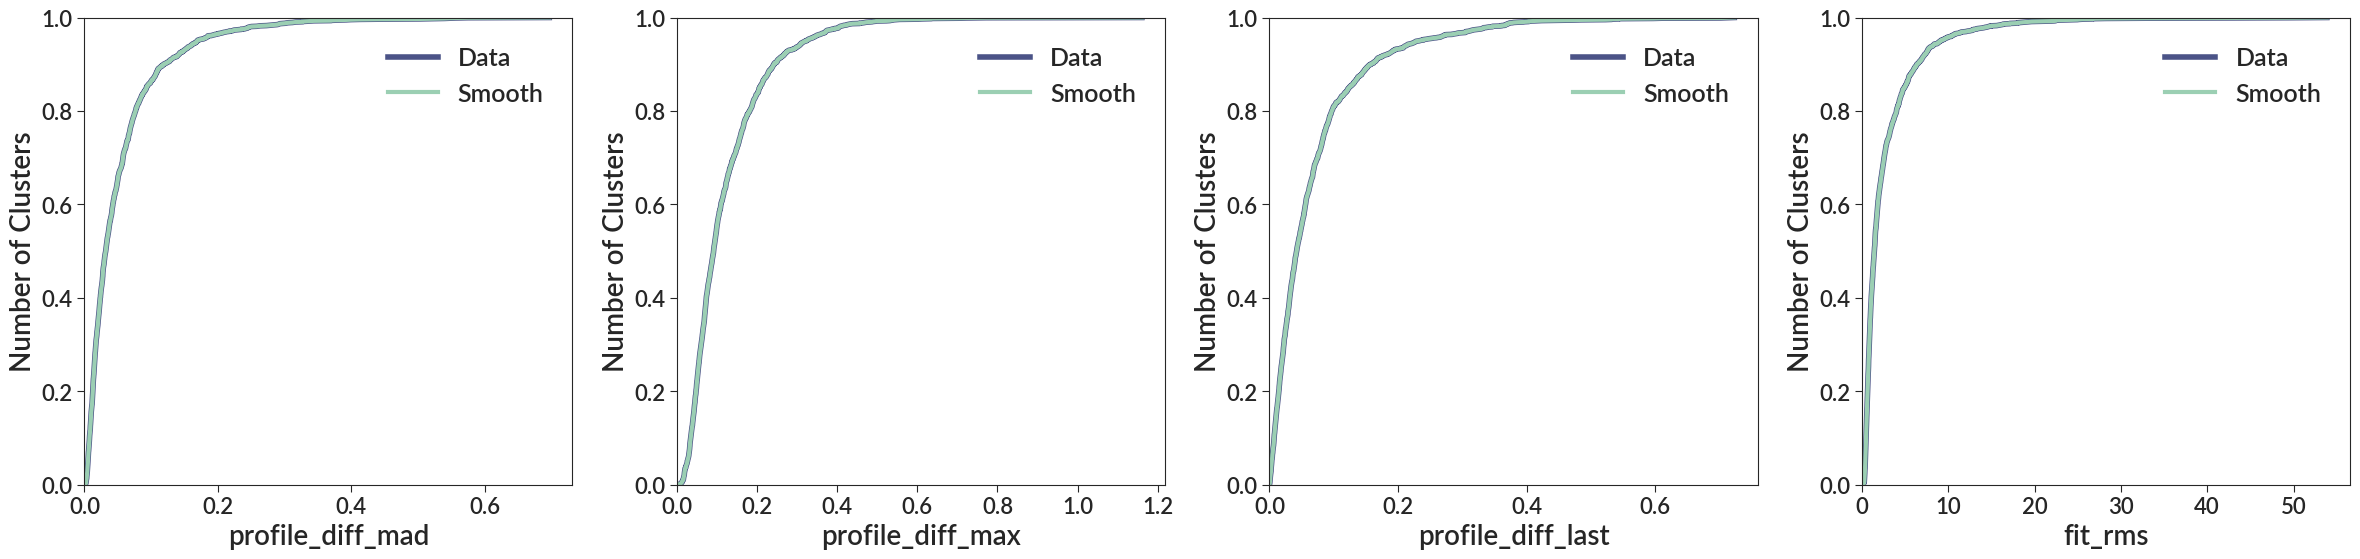

In [41]:
fig, axs = bpl.subplots(ncols=len(quality_colnames), figsize=[6*len(quality_colnames), 6])
axs = axs.flatten()

for ax, col in zip(axs, quality_colnames):
    xs, ys = make_cumulative_histogram(big_catalog[col])
    
    ax.plot(xs, ys, lw=4, label="Data")
    ax.add_labels(col, "Number of Clusters")
    ax.set_limits(0, y_min=0, y_max=1)
    
    smooth_ys = signal.savgol_filter(ys, 31, 11)
    
    ax.plot(xs, smooth_ys, lw=3, label="Smooth")
    
    ax.legend()

In [ ]:
fig, axs = bpl.subplots(ncols=len(quality_colnames), figsize=[6*len(quality_colnames), 6])
axs = axs.flatten()

for ax, col in zip(axs, quality_colnames):
    xs, ys = make_cumulative_histogram(big_catalog[col])
    
    ax.plot(xs, ys, lw=10, label="Data")
    ax.add_labels(col, "Number of Clusters")
    ax.set_limits(0, y_min=0)
    
    
    
    spline = interpolate.splrep(x=xs, y=ys, w=np.ones(len(xs)), k=3)
    
    spline_ys = interpolate.splev(xs, tck=spline, ext=0)
    
    ax.plot(xs, spline_ys, lw=4, label="Spline")
    
    # then find the maximum second derivative
    spline_d2 = spline_ys = interpolate.splev(xs, tck=spline, der=2)
    d2_max_idx = np.argmax(spline_d2)
    ax.axvline(xs[d2_max_idx])
    
    
    ax.legend()